# Homework 4

Raphaël Attali, Camille Morand-Duval, Niels Nicolas, Debdeep Roy

# Twitter sentiment index, index market returns and Granger causality

Financial markets react to news in various ways. The question here is if or how Tweets actually impact a broad stock market index. The May 7, 2019 Wall Steet Journal article ”Stocks Sink as Trade Tensions Mount” writes for example: ”The market will be pretty volatile in the next week or two reacting to headlines and comments and tweets.” Or on May 1, 2020, The Wall Street Journal article heads ’Elon Musk Tweeted That Tesla’s Stock Was Too High. The Market Agreed.’ In order to investigate if such impact is not only anecdotal but also true over longer periods, you will need to create a Twitter  sentiment time series, study its dynamic properties, and relate it to the stock market. The way you construct your sentiment time series is deliberately left to you.

In [2]:
import GetOldTweets3 as got
import pandas as pd
import csv
from datetime import date, timedelta, datetime
import re 
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

## Question 1
Extract from Twitter, daily tweets from people you might think influence the US stock market, e.g. Donald Trump. Note that rather than an index you can also take a stock like Tesla and check Elon Musk’s Tweets. Or aggregate sentiments from various people. Try to go back a couple of years in the past.

#### Comment
we chose to look into Elon Musk's tweets and their effect on Tesla's stock. We used this person because it has been shown that the behaviour of Elon Musk affects Tesla's stock. At repetition his action have caused drops in Tesla's stock, when he smoked pot during a podcast the stock closed down 6% or, more recently, when he tweeted 'Tesla stock price is too high imo' on may 1st and the stock fell by more than 10%. 

Additionally, we explored alternatives such as the public opinion of Musk (collecting 20 tweets per day and evaluating the sentiment on it). The results were inconclusive with that study. 

### Extract tweets

In [ ]:
with open("data/dummy.csv", 'w', encoding="utf-8") as f:
    # Wrap the file object by the writer.
    writer = csv.writer(f)
    
    # Write the header line to the output if needed.
    writer.writerow(['date', 'tweet'])
    
    start = date(2020, 5, 22)
    end = date.today()
    day = timedelta(days=1)

    mydate = start
    
    while mydate < end:
        print("{date.day:02}{date.month:02}{date.year}".format(date=mydate))
        
        tweetCriteria = got.manager.TweetCriteria().setUsername('elonmusk')\
                                           .setSince(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate)))\
                                           .setUntil(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate+day)))\
                                           .setTopTweets(True)\
                                           .setMaxTweets(240)
        
        mydate = mydate + day
        
    
        # Loop through the dictionary and get the tuples.
        # You may want to sort it somehow. Not shown here.
        for tweets in got.manager.TweetManager.getTweets(tweetCriteria):
            #writer.writerow(t)

            writer.writerow([tweets.date, tweets.text])

In [ ]:
with open("data/dummy.csv", 'w', encoding="utf-8") as f:
    # Wrap the file object by the writer.
    writer = csv.writer(f)
    
    # Write the header line to the output if needed.
    writer.writerow(['date', 'tweet'])
    
    start = date(2019, 6, 1)
    end = date.today()
    day = timedelta(days=1)

    mydate = start
    
    while mydate < end:
        print("{date.day:02}{date.month:02}{date.year}".format(date=mydate))
        
        tweetCriteria = got.manager.TweetCriteria().setQuerySearch('Musk')\
                                           .setSince(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate)))\
                                           .setUntil(("{date.year}-{date.month:02}-{date.day:02}".format(date=mydate+day)))\
                                           .setTopTweets(True)\
                                           .setMaxTweets(20)
        
        mydate = mydate + day
        
    
        # Loop through the dictionary and get the tuples.
        # You may want to sort it somehow. Not shown here.
        for tweets in got.manager.TweetManager.getTweets(tweetCriteria):
            #writer.writerow(t)

            writer.writerow([tweets.date, tweets.text])

### From csv

In [3]:
# elonmusk tweets
tweets = pd.read_csv('data/tesla.csv')
tweets.replace(" ", float("NaN"), inplace=True)
tweets.dropna(axis = 0, how ='any', inplace = True) # remove NA values

In [4]:
tweets.head()

,date,tweet
1,2019-06-01 23:44:47+00:00,"We’re trying to simplify product complexity, s..."
3,2019-06-01 00:35:15+00:00,Science
5,2019-06-01 00:05:02+00:00,Read it on @BBCScienceNews
9,2019-06-02 02:12:21+00:00,Exactly
11,2019-06-03 18:55:25+00:00,Only cars made in China are eligible for these...


In [5]:
# convert dates
tweets['date'] = tweets['date'].apply(lambda x: datetime.strptime(x.split(" ")[0], '%Y-%m-%d'))

In [6]:
min(tweets['date'])
tweets['date'].unique().shape

(349,)

In [7]:
tweets.head()

,date,tweet
1,2019-06-01,"We’re trying to simplify product complexity, s..."
3,2019-06-01,Science
5,2019-06-01,Read it on @BBCScienceNews
9,2019-06-02,Exactly
11,2019-06-03,Only cars made in China are eligible for these...


In [8]:
# public opinion
musk = pd.read_csv('data/Musk.csv')
musk.replace(" ", float("NaN"), inplace=True)
musk.dropna(axis = 0, how ='any', inplace = True) # remove NA values

# convert dates
musk['date'] = musk['date'].apply(lambda x: datetime.strptime(x.split(" ")[0], '%Y-%m-%d'))

musk.head()

,date,tweet
0,2019-06-01,Just continue to build affordable desirable lo...
1,2019-06-01,Just resign already elon
2,2019-06-01,So Australia is a high volume market?
3,2019-06-01,"??? Dana is great, she can tweet what she sees..."
4,2019-06-01,Text on Starlink website def sounds like you


### Extract stock values

In [9]:
# import external pandas_datareader library with alias of web
import pandas_datareader as web
 
# import datetime internal datetime module
# datetime is a Python module
import datetime
 
# datetime.datetime is a data type within the datetime module
start = datetime.datetime(2019, 5, 31)
end = datetime.datetime(2020, 6, 21)
 
# DataReader method name is case sensitive
stocks = web.DataReader("tsla", 'yahoo', start, end)

C:\Users\Camille\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Question 2
Do the necessary cleaning of the tweets and create a daily sentiment index time series. Explain your approach (number of tweets, number of words per tweets, etc).

#### Comment: 

To create a sentiment index time series, we used the NLTK library for cleaning, normalizing, lemmatization, tokenisation and sentiment analysis. This library includes dictionaries which can be used to train models for tweets' sentiment analysis. In this case, we used the positive tweet token library for training Naive Bayesian Classifier and achieved an accuracy of 0.993. 

For cleaning, we removed punctuation, stop words and symbols. We decided to keep only relevant tweets meaning tweets which length are strictly above 2 words. The output of the sentiment analysis is a probability of being positive. Therefore, the score computed for each tweet is between 0 and 1. 

Finally, the step which affected the reliability of the model the most is the daily aggregation. We tested a few methods, the best one being a weighted average of the sentiment scores by the length (number of words in a tweet). Other methods included ratio of the positive tweets (probability above 0.5) over all tweets in a day, keeping only tweets which included the word 'Tesla', standard average of the sentiment scores and sum of the sentiment scores. 

### Import twitter samples for training

In [10]:
nltk.download('twitter_samples')
nltk.download('punkt')
from nltk.corpus import twitter_samples

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Normalizing

In [11]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Lemmatization

In [12]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

print(tweet_tokens[0])
print(lemmatize_sentence(tweet_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


### Cleaning

In [13]:
import re, string
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [14]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

print(remove_noise(tweet_tokens[0], stop_words))

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Apply on training data

In [15]:
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [16]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

### Training & Testing Naive Bayes Classifier for sentiment analysis 

In [17]:
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [18]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy is: 0.997
Most Informative Features
                      :( = True           Negati : Positi =   2093.0 : 1.0
                      :) = True           Positi : Negati =   1625.4 : 1.0
                followed = True           Negati : Positi =     24.2 : 1.0
                follower = True           Positi : Negati =     21.7 : 1.0
                     bam = True           Positi : Negati =     20.5 : 1.0
                     sad = True           Negati : Positi =     19.2 : 1.0
                     x15 = True           Negati : Positi =     17.4 : 1.0
               community = True           Positi : Negati =     14.7 : 1.0
                    damn = True           Negati : Positi =     14.0 : 1.0
                 awesome = True           Positi : Negati =     13.1 : 1.0
None


### Application to Elon Musk tweets

In [19]:
#from nltk.tokenize import word_tokenize

#custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."
#custom_tokens = remove_noise(word_tokenize(custom_tweet))
#dist = classifier.prob_classify(dict([token, True] for token in custom_tokens))

#print(dist.prob("Positive"))
#print(dist.prob("Negative"))

In [20]:
from nltk.tokenize import word_tokenize

def sentiment_analysis(tweet):
    tweet = remove_noise(word_tokenize(str(tweet)))
    dist = classifier.prob_classify(dict([token, True] for token in tweet))
    sentiment = dist.prob("Positive")
    return sentiment

tweets['sentiment'] = tweets['tweet'].apply(lambda x: sentiment_analysis(x))

In [21]:
# length of tweet
tweets['length'] = tweets['tweet'].apply(lambda x: len(str(x).split(" ")))

In [22]:
tweets.head()

,date,tweet,sentiment,length
1,2019-06-01,"We’re trying to simplify product complexity, s...",0.960806,19
3,2019-06-01,Science,0.785715,2
5,2019-06-01,Read it on @BBCScienceNews,0.625001,4
9,2019-06-02,Exactly,0.583334,1
11,2019-06-03,Only cars made in China are eligible for these...,0.524558,17


In [23]:
# keeping only tweets with more than two words
tweets = tweets[tweets['length']>2]

# Tesla mentionned ? 
#tweets['tesla'] = tweets['tweet'].apply(lambda x: 'Tesla' in x)
#tweets['tesla'] = tweets['tesla'].apply(lambda x: 1 if (x == True) else 0)
#tweets = tweets[tweets['tesla'] == 1]

# Sentiment by 1 or 0
tweets['bol_sentiment'] = tweets['sentiment'].apply(lambda x: 1 if (x >= 0.5) else 0)
tweets['count'] = 1

#### Aggregate per day

In [24]:
import numpy as np
# weighted average using the length of tweets
tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.average(x['sentiment'], weights=x['length'])], index=['sentiment'])).unstack()

# average sentiment over a day
#tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.average(x['sentiment'])], index=['sentiment'])).unstack()

# sum sentiment over a day
#tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.sum(x['sentiment'])], index=['sentiment'])).unstack()

# ratio tesla only
#tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.sum(x['bol_sentiment']) / np.sum(x['tesla'])], index=['sentiment'])).unstack()

# ratio all tweets
#tweets_day = tweets.groupby(['date']).apply(lambda x: pd.Series([np.sum(x['bol_sentiment']) / np.sum(x['count'])], index=['sentiment'])).unstack()

tweets_day = pd.DataFrame(tweets_day).reset_index().drop(columns=['level_0']).rename(columns={0: 'score'})

In [25]:
print('max', tweets_day['score'].max())
print('min', tweets_day['score'].min())
print('shape', tweets_day.shape)
tweets_day.head()

max 0.9999090300282377
min 0.010480124454637758
shape (341, 2)


,date,score
0,2019-06-01,0.902405
1,2019-06-03,0.524558
2,2019-06-04,0.334655
3,2019-06-05,0.971150
4,2019-06-07,0.741334


#### Sentiment index (score) vs. time

Text(0, 0.5, 'sentiment index')

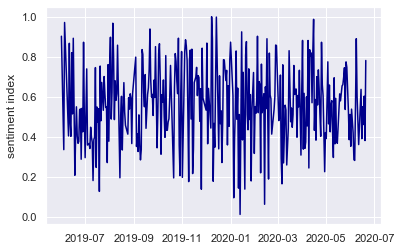

In [26]:
plt.plot(tweets_day['date'], tweets_day['score'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('sentiment index')

### Query Search 'Musk'

#### Comment
This dataset was not kept for the final model. We applied the same sentiment analysis but we obtained no Granger Causality between the sentiment index and the Tesla stock log-returns. The aggregation between Elon Musk's tweets and public opinion was done though multiplication of the sentiment scores. 

In [27]:
musk['sentiment'] = musk['tweet'].apply(lambda x: sentiment_analysis(x))

# length of tweet
musk['length'] = musk['tweet'].apply(lambda x: len(str(x).split(" ")))

# keeping only tweets with more than two words
musk = musk[musk['length']>2]

# Sentiment by 1 or 0
musk['bol_sentiment'] = musk['sentiment'].apply(lambda x: 1 if (x >= 0.5) else 0)
musk['count'] = 1

In [28]:
musk.head()

,date,tweet,sentiment,length,bol_sentiment,count
0,2019-06-01,Just continue to build affordable desirable lo...,0.975943,31,1,1
1,2019-06-01,Just resign already elon,0.361112,4,0,1
2,2019-06-01,So Australia is a high volume market?,0.958921,8,1,1
3,2019-06-01,"??? Dana is great, she can tweet what she sees...",0.978268,12,1,1
4,2019-06-01,Text on Starlink website def sounds like you,0.590096,9,1,1


#### Aggregate per day

In [29]:
import numpy as np

# average sentiment over a day
musk_day = musk.groupby(['date']).apply(lambda x: pd.Series([np.average(x['sentiment'])], index=['sentiment'])).unstack()
musk_day = pd.DataFrame(musk_day).reset_index().drop(columns=['level_0']).rename(columns={0: 'score'})

In [30]:
print('max', musk_day['score'].max())
print('min', musk_day['score'].min())
print('shape', musk_day.shape)
musk_day.head()

max 0.7922940525762235
min 0.31883653338811524
shape (387, 2)


,date,score
0,2019-06-01,0.664051
1,2019-06-02,0.568323
2,2019-06-03,0.564120
3,2019-06-04,0.620452
4,2019-06-05,0.707051


#### Sentiment index (score) vs. time

Text(0, 0.5, 'sentiment index')

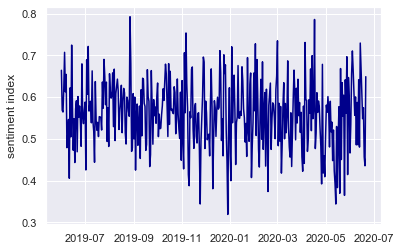

In [31]:
plt.plot(musk_day['date'],musk_day['score'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('sentiment index')

### Final aggregation

In [32]:
tweets_day.head()
tweets_day.isna().sum()
tweets_day.shape

(341, 2)

In [33]:
musk_day.head()
musk_day.isna().sum()
musk_day.shape

(387, 2)

In [34]:
#final_df = tweets_day['score'] * musk_day['score']
final_df = pd.DataFrame({'date': musk_day['date'], 'score': tweets_day['score'] * musk_day['score']})
final_df.replace(" ", float("NaN"), inplace=True)
final_df.dropna(axis = 0, how ='any', inplace = True) # remove NA values
final_df.head()

,date,score
0,2019-06-01,0.599243
1,2019-06-02,0.298118
2,2019-06-03,0.188786
3,2019-06-04,0.602552
4,2019-06-05,0.524161


#### Sentiment index (score) vs. time

Text(0, 0.5, 'sentiment index')

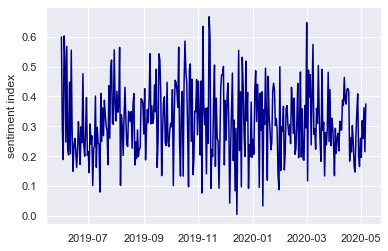

In [35]:
plt.plot(final_df['date'],final_df['score'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('sentiment index')

## Question 3
Study the properties of the sentiment index time series, descriptive statistics, ACF, and develop/estimate a time series model for it (AR, MA, ARMA).

### Descriptive statistics

Text(0, 0.5, 'frequency')

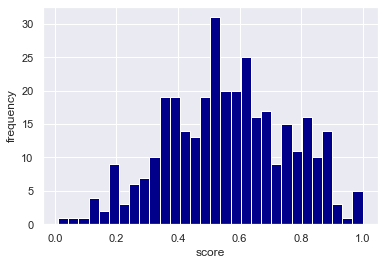

In [36]:
plt.hist(tweets_day['score'], bins = 30, color = 'darkblue')
plt.xlabel('score')
plt.ylabel('frequency')

In [37]:
mean = tweets_day['score'].mean()
variance = tweets_day['score'].var()
skewness = tweets_day['score'].skew()
kurtosis = tweets_day['score'].kurt()

print('mean:', mean) 
print('variance:', variance)
print('skewness:', skewness)
print('kurtosis:', kurtosis)

mean: 0.5597332545936452
variance: 0.039746539671710344
skewness: -0.08997433831476385
kurtosis: -0.4730654514896253


#### Comment 
The sentiment index values are distributed betweeen 0 and 1. They are centered around 0.55 (which is explained by the token dictionnary used) with a variance of 0.04. The skewness and kurtosis are not significant. 

### ACF

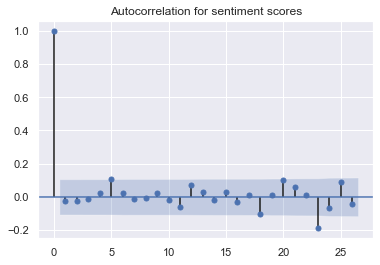

In [38]:
sm.graphics.tsa.plot_acf(tweets_day['score'])
plt.title('Autocorrelation for sentiment scores')
plt.show()

C:\Users\Camille\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


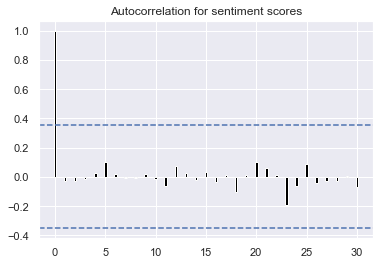

In [39]:
# Jeroen's code - ARMASIM-1
tweets_acf = acf(tweets_day['score'], nlags=30) # doesn't work above 40 (every 10)
x = range(0,31)
plt.bar(x,tweets_acf,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.title('Autocorrelation for sentiment scores')
plt.show()

#### Comment
The ACF shows no significant lags. 

### PACF

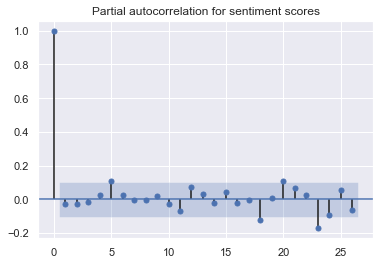

In [40]:
sm.graphics.tsa.plot_pacf(tweets_day['score'])
plt.title('Partial autocorrelation for sentiment scores')
plt.show()

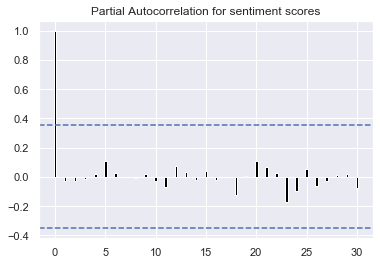

In [41]:
# Jeroen's code - ARMASIM-1
tweets_acf = pacf(tweets_day['score'], nlags=30)
x = range(0,31)
plt.bar(x,tweets_acf,1/4, color="black")
plt.axhline(y=-1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.axhline(y=1.96/np.sqrt(len(tweets_acf)),linestyle='--',color='b')
plt.title('Partial Autocorrelation for sentiment scores')
plt.show()

#### Comment
The PACF shows no significant lags. 

### Model Design

#### Comment
Given the ACF and the PACF we can only choose a ARMA(0,0) model (constant only). There are no significant lags on either of the ACF and PACF plots. We looked into the ARMA(0,0) model following the previous conclusion and compared it to an AR(1) and MA(1) for information only. 

We are choosing the AIC and the significance of the coefficient for model selection. In all cases, the AIC is very high (-170 to -172) and the coefficients are not significant. 

In [42]:
# Jeroen's code - ARMASIM-1
# ARMA(0,0)
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tweets_day['score'], order=(0,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  341
Model:                     ARMA(0, 0)   Log Likelihood                  66.545
Method:                           css   S.D. of innovations              0.199
Date:                Tue, 23 Jun 2020   AIC                           -129.090
Time:                        13:48:30   BIC                           -121.426
Sample:                             0   HQIC                          -126.036
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5597      0.011     51.921      0.000       0.539       0.581


In [43]:
# Jeroen's code - ARMASIM-1
# ARMA(1,0)
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tweets_day['score'], order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  341
Model:                     ARMA(1, 0)   Log Likelihood                  66.659
Method:                       css-mle   S.D. of innovations              0.199
Date:                Tue, 23 Jun 2020   AIC                           -127.318
Time:                        13:48:31   BIC                           -115.822
Sample:                             0   HQIC                          -122.738
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5597      0.011     53.279      0.000       0.539       0.580
ar.L1.score    -0.0260      0.054     -0.478      0.633      -0.133       0.081
                                    Roots       

In [44]:
# Jeroen's code - ARMASIM-1
# ARMA(0,1)
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tweets_day['score'], order=(0,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  341
Model:                     ARMA(0, 1)   Log Likelihood                  66.666
Method:                       css-mle   S.D. of innovations              0.199
Date:                Tue, 23 Jun 2020   AIC                           -127.332
Time:                        13:48:31   BIC                           -115.836
Sample:                             0   HQIC                          -122.752
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5597      0.010     53.401      0.000       0.539       0.580
ma.L1.score    -0.0276      0.056     -0.492      0.623      -0.137       0.082
                                    Roots       

#### Comment 
We explored one of the models further for information only. 

### MA(1)

In [45]:
# Jeroen's code - ARMASIM-1
model_fit.params #coef param

const          0.559688
ma.L1.score   -0.027561
dtype: float64

In [46]:
model_fit.cov_params() #cov matrix

,const,ma.L1.score
const,0.000110,0.000005
ma.L1.score,0.000005,0.003138


#### Residuals

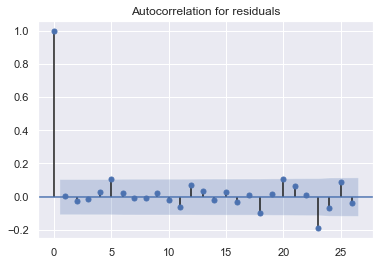

In [47]:
sm.graphics.tsa.plot_acf(model_fit.resid)
plt.title('Autocorrelation for residuals')
plt.show()

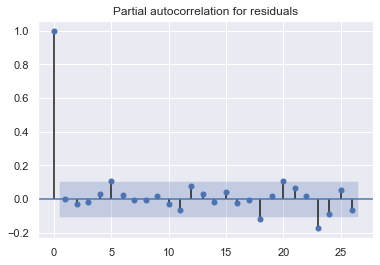

In [48]:
sm.graphics.tsa.plot_pacf(model_fit.resid)
plt.title('Partial autocorrelation for residuals')
plt.show()

#### Forecast

In [49]:
#forecasting
T = len(tweets_day['score'])
tweet_res = model_fit.resid
tweet_sig2 = model_fit.sigma2
tweet_coef = model_fit.params
theta_1 = tweet_coef[0]
mu = tweet_coef[1]
hor = 10
forecast = np.ones((hor), dtype = float);
forecastvar = np.zeros((hor), dtype = float);
forecast[0] = mu + theta_1 * tweet_res[T - 1]
forecastvar[0] = tweet_sig2

In [50]:
for i in range(1,hor):
    forecast[i]=mu
    forecastvar[i]=tweet_sig2*np.power(1+theta_1,2)

In [51]:
#variables for plot
T0=T-100
y=np.append(tweets_day['score'][T0:T],forecast)
uppr=forecast+2*np.sqrt(forecastvar)
lwr=forecast-2*np.sqrt(forecastvar)
y_up=np.append(tweets_day['score'][T0:T], uppr)
y_lo=np.append(tweets_day['score'][T0:T], lwr)

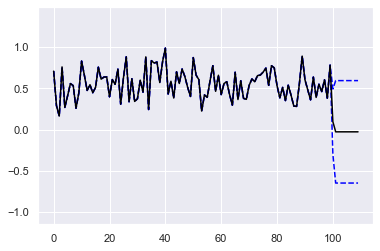

In [52]:
plt.plot(y_lo,color='blue', linestyle='--')
plt.plot(y_up,color='blue', linestyle='--')
plt.plot(y,color='black')


plt.ylim(np.min(y_lo)-0.5, np.max(y_up)+0.5)
plt.show()

In [62]:
# auto arima
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt

# fit your model
model = pm.auto_arima(tweets_day['score'], seasonal = False, m = 10)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  341
Model:                        SARIMAX   Log Likelihood                  66.545
Date:                Tue, 23 Jun 2020   AIC                           -129.090
Time:                        15:22:52   BIC                           -121.426
Sample:                             0   HQIC                          -126.036
                                - 341                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5597      0.011     51.784      0.000       0.539       0.581
sigma2         0.0396      0.003     11.339      0.000       0.033       0.046
===================================================================================
Ljung-Box (Q):                       46.61   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.22   Prob(JB):                         0.15
Heteroskedasticity (H):               0.88   Skew:                            -0.09
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Question 4
For the same period as your sentiment time series, download S&P 500 (or stock)
daily closing prices and transform the series into log returns. Make time series plots
and compare with the sentiment series.

#### Comment
We downloaded the Tesla stock adjusted closed prices between the same dates as the tweets and calculaed the log returns. The PACF and ACF are similar to the sentiment analysis ones, there is no significant lag in either. 

In [52]:
# log returns
log_stock = np.log(stocks['Adj Close']) 
log_returns = np.diff(log_stock)*100
log_stock.shape

# stocks
log_returns = pd.DataFrame({'date': stocks.reset_index()['Date'][1:], 'log_returns': log_returns})
log_returns.head()

,date,log_returns
1,2019-06-03,-3.400214
2,2019-06-04,7.857601
3,2019-06-05,1.532612
4,2019-06-06,4.651308
5,2019-06-07,-0.706543


Text(0, 0.5, 'log returns')

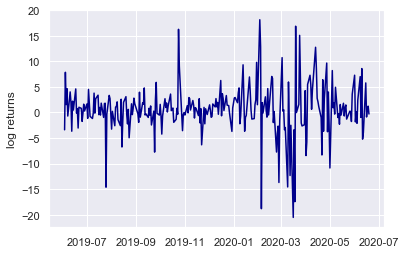

In [53]:
plt.plot(log_returns['date'],log_returns['log_returns'], color = 'darkblue')
#plt.xlabel('date')
plt.ylabel('log returns')

### Time series plots

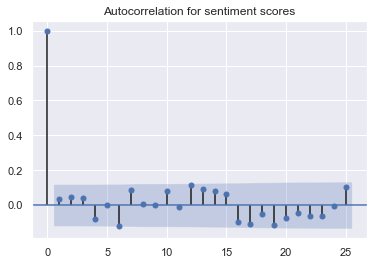

In [54]:
sm.graphics.tsa.plot_acf(log_returns['log_returns'])
plt.title('Autocorrelation for sentiment scores')
plt.show()

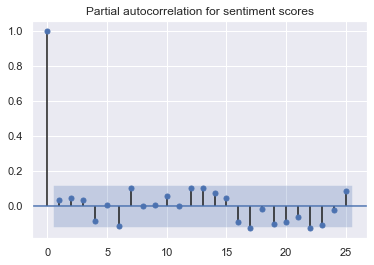

In [55]:
sm.graphics.tsa.plot_pacf(log_returns['log_returns'])
plt.title('Partial autocorrelation for sentiment scores')
plt.show()

## Question 5 
Test for Granger causality between the two time series.

#### Comment
To test for Granger causality between the sentiment score index time series and the log-returns of the Tesla stocks, we first test for stability using an Augmented Dickey Fuller test. It is verified in both cases, the p-values are below 0.05 meaning we can reject the hypothesis of non-stationarity. 

Using the library 'statsmodels' we test for Granger causality i.e. whether the sentiment index has an effect on the log-returns. The p-value is below 0.05 for lags between 1 and 8 meaning some Granger causality exists between the series. 

In [56]:
# stationarity test
from statsmodels.tsa.stattools import adfuller
adfuller(tweets_day['score'], autolag ='AIC')
# HENCE STATIONARY

(-6.6421993767113925,
 5.3748518548815874e-09,
 7,
 333,
 {'1%': -3.450141065277327,
  '5%': -2.870258846235788,
  '10%': -2.571415151457764},
 -165.25027166799725)

In [57]:
# stationarity test
adfuller(log_returns['log_returns'], autolag ='AIC')
# HENCE STATIONARY

(-15.68506896110618,
 1.4568102591407303e-28,
 0,
 265,
 {'1%': -3.4552699038400827,
  '5%': -2.8725092359464526,
  '10%': -2.5726152830188678},
 1497.6415237645338)

In [58]:
#tweets_day = tweets_day.set_index('date')
#log_returns = log_returns.set_index('date')
dataset = pd.concat([log_returns.log_returns, tweets_day.score], axis = 1)
dataset = dataset.fillna(method = 'pad')
dataset = dataset.dropna()
dataset.isnull().sum()

log_returns    0
score          0
dtype: int64

In [59]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 10
grangercausalitytests(dataset, maxlag)

# GRANGER CAUSALITY @ LAGS 1 - 8


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2803  , p=0.0127  , df_denom=336, df_num=1
ssr based chi2 test:   chi2=6.3364  , p=0.0118  , df=1
likelihood ratio test: chi2=6.2779  , p=0.0122  , df=1
parameter F test:         F=6.2803  , p=0.0127  , df_denom=336, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4428  , p=0.0047  , df_denom=333, df_num=2
ssr based chi2 test:   chi2=11.0491 , p=0.0040  , df=2
likelihood ratio test: chi2=10.8724 , p=0.0044  , df=2
parameter F test:         F=5.4428  , p=0.0047  , df_denom=333, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5733  , p=0.0143  , df_denom=330, df_num=3
ssr based chi2 test:   chi2=10.9473 , p=0.0120  , df=3
likelihood ratio test: chi2=10.7732 , p=0.0130  , df=3
parameter F test:         F=3.5733  , p=0.0143  , df_denom=330, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1910  , p=0.0136  

{1: ({'ssr_ftest': (6.280339802954516, 0.012680634382463802, 336.0, 1),
   'ssr_chi2test': (6.336414265480896, 0.011828376203254796, 1),
   'lrtest': (6.277923490398734, 0.012225126668032578, 1),
   'params_ftest': (6.280339802954514, 0.012680634382463802, 336.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.442837003710308, 0.0047208469166333195, 333.0, 2),
   'ssr_chi2test': (11.049122566090595, 0.003987617743944035, 2),
   'lrtest': (10.872367973746577, 0.004356074431774022, 2),
   'params_ftest': (5.442837003710317, 0.0047208469166333195, 333.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.5732874560880217, 0.014324077676636017, 330.0, 3),
   'ssr_chi2test': (10.947253388196941, 0.012014542587676588, 3),
   'lrtest': (10.77320494995115, 0.01301763634371134, 3),
   'params_ftest': (3.5732874560880314, 0.01432407767663583, 330.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      